**MACHINE LEARNING**

In [1]:
!pip install underthesea sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.4/978.4 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.1 MB/s eta 0:00:00


In [2]:
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/dataNLP.json"
with open(path, encoding="utf-8") as f:
    raw_data = json.load(f)

print(len(raw_data))

Mounted at /content/drive
1000


In [4]:
def extract_entities(item):
    entities = []
    if "annotations" not in item:
        return entities

    for ann in item["annotations"]:
        for res in ann["result"]:
            val = res["value"]
            start = val["start"]
            end = val["end"]
            label = val["labels"][0]
            entities.append((start, end, label))
    return entities

In [5]:
from underthesea import word_tokenize

def bio_from_labelstudio(text, entities):
    tokens = word_tokenize(text, format="text").split()
    tags = ["O"] * len(tokens)

    char_idx = 0
    token_spans = []

    for tok in tokens:
        start = text.find(tok, char_idx)
        end = start + len(tok)
        token_spans.append((start, end))
        char_idx = end

    for ent_start, ent_end, label in entities:
        first = True
        for i, (tok_start, tok_end) in enumerate(token_spans):
            if tok_start >= ent_start and tok_end <= ent_end:
                tags[i] = ("B-" if first else "I-") + label
                first = False

    return tokens, tags

In [6]:
sentences = []   # list of token lists
labels = []      # list of BIO tag lists

for item in raw_data:
    text = item["data"]["text"]
    entities = extract_entities(item)

    tokens, tags = bio_from_labelstudio(text, entities)

    if len(tokens) > 0:
        sentences.append(tokens)
        labels.append(tags)

In [7]:
num_sentences = len(sentences)
num_tokens = sum(len(s) for s in sentences)

print("Số câu:", num_sentences)
print("Tổng số token:", num_tokens)
print("Token trung bình / câu:", num_tokens / num_sentences)

Số câu: 1000
Tổng số token: 16536
Token trung bình / câu: 16.536


In [8]:
from collections import Counter

label_counter = Counter()

for tag_seq in labels:
    label_counter.update(tag_seq)

label_counter

Counter({'O': 7482,
         'B-LOCATION': 286,
         'B-ACTIVITY': 718,
         'B-TIME': 292,
         'B-ATTRACTION': 988,
         'I-ATTRACTION': 2551,
         'I-TIME': 747,
         'I-ACTIVITY': 1829,
         'B-COST': 216,
         'I-COST': 1192,
         'I-LOCATION': 235})

In [9]:
def strip_bio(tag):
    return tag[2:] if tag.startswith(("B-", "I-")) else tag

entity_counter = Counter(strip_bio(t) for t in label_counter)

entity_counter

Counter({'O': 1,
         'LOCATION': 2,
         'ACTIVITY': 2,
         'TIME': 2,
         'ATTRACTION': 2,
         'COST': 2})

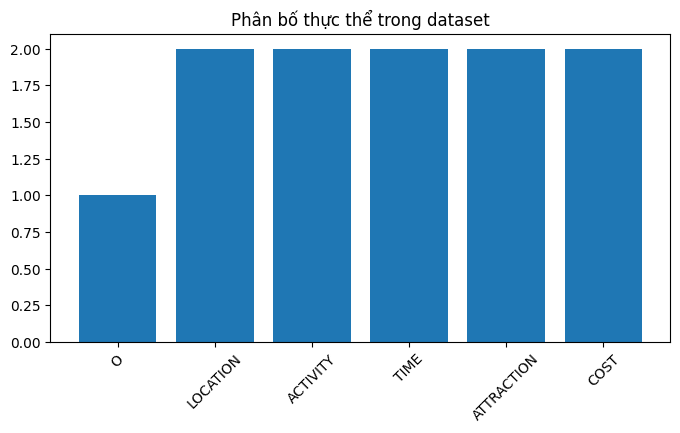

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(entity_counter.keys(), entity_counter.values())
plt.title("Phân bố thực thể trong dataset")
plt.xticks(rotation=45)
plt.show()

In [11]:
o_count = label_counter["O"]
entity_count = num_tokens - o_count

print("O tokens:", o_count)
print("Entity tokens:", entity_count)
print("Tỷ lệ entity:", entity_count / num_tokens)

O tokens: 7482
Entity tokens: 9054
Tỷ lệ entity: 0.5475326560232221


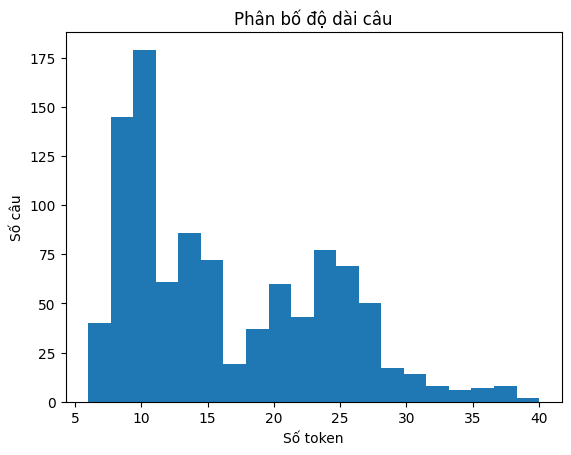

In [12]:
sentence_lengths = [len(s) for s in sentences]

plt.hist(sentence_lengths, bins=20)
plt.title("Phân bố độ dài câu")
plt.xlabel("Số token")
plt.ylabel("Số câu")
plt.show()

In [13]:
entity_counter.most_common()

[('LOCATION', 2),
 ('ACTIVITY', 2),
 ('TIME', 2),
 ('ATTRACTION', 2),
 ('COST', 2),
 ('O', 1)]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    sentences,
    labels,
    test_size=0.2,
    random_state=42
)

print("Train sentences:", len(X_train))
print("Test sentences:", len(X_test))

Train sentences: 800
Test sentences: 200


In [15]:
### DATA CRF

def word2features(sent, i):
    word = sent[i]
    features = {
        "bias": 1.0,
        "word.lower": word.lower(),
        "word.isupper": word.isupper(),
        "word.istitle": word.istitle(),
        "word.isdigit": word.isdigit(),
    }

    if i > 0:
        features["-1:word.lower"] = sent[i-1].lower()
    else:
        features["BOS"] = True

    if i < len(sent) - 1:
        features["+1:word.lower"] = sent[i+1].lower()
    else:
        features["EOS"] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


X_crf = [sent2features(s) for s in sentences]
y_crf = labels

In [16]:
### TOKEN FEATURES (SVM + LOGREG)

def token_features(token):
    return {
        "word.lower": token.lower(),
        "word.isupper": token.isupper(),
        "word.istitle": token.istitle(),
        "word.isdigit": token.isdigit(),
    }

In [17]:
### FLATTEN DATA

X_flat = []
y_flat = []

for sent, tag_seq in zip(sentences, labels):
    for tok, tag in zip(sent, tag_seq):
        X_flat.append(token_features(tok))
        y_flat.append(tag)

In [18]:
### VECTORIZE
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=True)
X_vec = vec.fit_transform(X_flat)

In [19]:
print("CRF:", len(X_crf), len(y_crf))
print("Token-level:", X_vec.shape, len(y_flat))

CRF: 1000 1000
Token-level: (16536, 2356) 16536


In [20]:
### TRAIN LOGREG
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)
logreg.fit(X_vec, y_flat)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [21]:
### TRAIN SVM
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_vec, y_flat)

LinearSVC()

In [22]:
### TRAIN CRF
import sklearn_crfsuite

crf = sklearn_crfsuite.CRF(
    algorithm="lbfgs",
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_crf, y_crf)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [23]:
### ĐÁNH GIÁ LOGREG/ SVM
from sklearn.metrics import classification_report

y_pred_logreg = logreg.predict(X_vec)
y_pred_svm = svm.predict(X_vec)

print("LOGISTIC REGRESSION")
print(classification_report(y_flat, y_pred_logreg))

print("SVM")
print(classification_report(y_flat, y_pred_svm))

LOGISTIC REGRESSION
              precision    recall  f1-score   support

  B-ACTIVITY       0.30      0.68      0.42       718
B-ATTRACTION       0.43      0.46      0.44       988
      B-COST       0.27      0.75      0.40       216
  B-LOCATION       0.35      0.71      0.47       286
      B-TIME       0.27      0.65      0.38       292
  I-ACTIVITY       0.56      0.43      0.49      1829
I-ATTRACTION       0.54      0.26      0.35      2551
      I-COST       0.45      0.78      0.57      1192
  I-LOCATION       0.15      0.62      0.24       235
      I-TIME       0.40      0.48      0.44       747
           O       0.95      0.69      0.80      7482

    accuracy                           0.58     16536
   macro avg       0.42      0.59      0.45     16536
weighted avg       0.68      0.58      0.60     16536

SVM
              precision    recall  f1-score   support

  B-ACTIVITY       0.41      0.50      0.45       718
B-ATTRACTION       0.66      0.41      0.51       988


In [24]:
### ĐÁNH GIÁ CRF
from sklearn_crfsuite.metrics import flat_classification_report

labels_eval = [
    "B-LOCATION","I-LOCATION",
    "B-ATTRACTION","I-ATTRACTION",
    "B-ACTIVITY","I-ACTIVITY",
    "B-TIME","I-TIME",
    "B-COST","I-COST"
]

y_pred_crf = crf.predict(X_crf)

print(flat_classification_report(
    y_crf,
    y_pred_crf,
    labels=labels_eval,
    digits=3
))

              precision    recall  f1-score   support

  B-LOCATION      0.861     0.804     0.832       286
  I-LOCATION      0.869     0.817     0.842       235
B-ATTRACTION      0.891     0.823     0.856       988
I-ATTRACTION      0.857     0.882     0.869      2551
  B-ACTIVITY      0.867     0.825     0.845       718
  I-ACTIVITY      0.836     0.859     0.847      1829
      B-TIME      0.820     0.781     0.800       292
      I-TIME      0.824     0.802     0.813       747
      B-COST      0.791     0.755     0.773       216
      I-COST      0.917     0.963     0.939      1192

   micro avg      0.860     0.860     0.860      9054
   macro avg      0.853     0.831     0.842      9054
weighted avg      0.860     0.860     0.860      9054



In [25]:
### DEMO
test_text = """
Tháng 12, du khách có thể tham quan Phú Quốc với chi phí khoảng 5 triệu đồng.
"""

In [26]:
tokens = word_tokenize(test_text, format="text").split()
print(tokens)

['Tháng', '12', ',', 'du_khách', 'có_thể', 'tham_quan', 'Phú_Quốc', 'với', 'chi_phí', 'khoảng', '5', 'triệu', 'đồng', '.']


In [27]:
### DEMO CRF
X_test_crf = [sent2features(tokens)]
y_pred_crf = crf.predict(X_test_crf)[0]

print("=== CRF Prediction ===")
for tok, tag in zip(tokens, y_pred_crf):
    print(f"{tok:15} {tag}")

=== CRF Prediction ===
Tháng           B-TIME
12              I-TIME
,               O
du_khách        O
có_thể          O
tham_quan       O
Phú_Quốc        O
với             O
chi_phí         O
khoảng          B-COST
5               I-COST
triệu           I-COST
đồng            I-COST
.               I-COST


In [28]:
### DEMO LOGREG
X_test_flat = [token_features(tok) for tok in tokens]
X_test_vec = vec.transform(X_test_flat)

y_pred_logreg = logreg.predict(X_test_vec)

print("\n=== Logistic Regression Prediction ===")
for tok, tag in zip(tokens, y_pred_logreg):
    print(f"{tok:15} {tag}")


=== Logistic Regression Prediction ===
Tháng           B-TIME
12              I-TIME
,               I-LOCATION
du_khách        O
có_thể          O
tham_quan       O
Phú_Quốc        O
với             B-COST
chi_phí         O
khoảng          I-COST
5               B-TIME
triệu           I-COST
đồng            I-COST
.               I-COST


In [29]:
### DEMO SVM
y_pred_svm = svm.predict(X_test_vec)

print("\n=== SVM Prediction ===")
for tok, tag in zip(tokens, y_pred_svm):
    print(f"{tok:15} {tag}")


=== SVM Prediction ===
Tháng           B-TIME
12              I-TIME
,               O
du_khách        O
có_thể          O
tham_quan       O
Phú_Quốc        O
với             O
chi_phí         O
khoảng          I-COST
5               B-TIME
triệu           I-COST
đồng            I-COST
.               O


In [30]:
def extract_entities_from_bio(tokens, tags):
    entities = []
    current_entity = []
    current_label = None

    for tok, tag in zip(tokens, tags):
        if tag.startswith("B-"):
            if current_entity:
                entities.append((current_label, " ".join(current_entity)))
            current_label = tag[2:]
            current_entity = [tok]
        elif tag.startswith("I-") and current_label == tag[2:]:
            current_entity.append(tok)
        else:
            if current_entity:
                entities.append((current_label, " ".join(current_entity)))
                current_entity = []
                current_label = None

    if current_entity:
        entities.append((current_label, " ".join(current_entity)))

    return entities

In [31]:
print("\n=== CRF Extracted Entities ===")
for label, text in extract_entities_from_bio(tokens, y_pred_crf):
    print(f"{label}: {text}")


=== CRF Extracted Entities ===
TIME: Tháng 12
COST: khoảng 5 triệu đồng .
